In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

### Import mamtorch library
You need to have mamtorch folder in this directory and to install mamtorchkernel by launching, from mamtorch folder, "python kernelsetup.py install" (to improve compiling time, install ninja through "pip install ninja")

In [2]:
import mamtorch # Remember to install mamtorchkernel through mamtorch/kernelsetup.py

### Select the GPU
Currently, MAM kernels are implemented only for usage on GPU

In [3]:
# Select GPU
gpu_id = 0
# Check if the GPU is available, and if so, use it
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
# You need a gpu to use MAM kernel! (No cpu-based implementation available)
if(device == "cpu"):
    raise "No GPU device available! MAM kernels are not available."

### Define a simple feedforward DNN containing a MAM layer

In [4]:
# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, input_channels, output_channels0, kernel_size0, output_channels1, kernel_size1, num_classes):
        super(SimpleNN, self).__init__()
        
        self.conv2d_0_mac = nn.Conv2d(input_channels, output_channels0, kernel_size0, bias=True, padding="valid")
        self.relu_0 = nn.ReLU()
        
        # evaluate output shape of the conv layer
        x = torch.ones(1, input_channels, input_size[0], input_size[1])
        x = torch.nn.functional.conv2d(x, self.conv2d_0_mac.weight, padding="valid")
        self.hidden_size0 = (x.shape[2], x.shape[3])
        
        # Instantiate a MAM conv2d layer
        self.conv2d_1_mam = mamtorch.MAMConv2d(output_channels0, output_channels1, kernel_size1, bias=True, beta=True, beta_epochs=4, padding="valid")
        self.relu_1 = nn.ReLU()
        
        # evaluate output shape of the conv layer
        x = torch.ones(1, output_channels0, self.hidden_size0[0], self.hidden_size0[1])
        x = torch.nn.functional.conv2d(x, self.conv2d_1_mam.weight, padding="valid")
        self.hidden_size2 = x.flatten().shape[0]
        
        # Instantiate the output layer
        self.fc_2 = nn.Linear(self.hidden_size2, num_classes)

    def forward(self, x):
        x = self.conv2d_0_mac(x)
        x = self.relu_0(x)
        x = self.conv2d_1_mam(x)
        x = self.relu_1(x)
        x = x.view(-1, self.hidden_size2)
        x = self.fc_2(x)
        return x
    
# Hyperparameters
input_size = (28, 28)  # MNIST image size
input_channels = 1
output_channels0 = 64
output_channels1 = 16
kernel_size0 = (3, 3)
kernel_size1 = (3, 3)
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

Load MNIST dataset and apply transformations

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Initialize the model, loss function, and optimizer

In [6]:
model = SimpleNN(input_size, input_channels, output_channels0, kernel_size0, output_channels1, kernel_size1, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train the network

In [7]:
# Initialize the selection matrix list.
# Here, for each training epoch, we store the number of times each interconnection has been used
# I.E., the selection count
selection_matrix_list = []

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    start_time = time.perf_counter()
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    model.train() # se training mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Training step [{i + 1}/{total_step}], Loss: {loss.item():.4f}', end='\r')
    print()
    
    print("Validation...", end="\r")
    model.eval() # set evaluation mode
    
    # reset the selection count in the mam layer
    model.conv2d_1_mam.reset_selection_count()
    
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        
        # update the selection count with the results of this batch
        model.conv2d_1_mam.update_selection_count()
        
        # get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        
        # evaluate the correct values agaist the total evaluated
        correct += (predicted == labels.to(device)).sum().item()
        total += labels.size(0)
    
    # evaluate accuracy
    accuracy = correct / total
    print(f'Validation accuracy on test set: {accuracy*100:.2f}%')
    
    # add evaluated selection count matrix to the list
    # (as the sum of the count of interconnections selected as maximum and as minimum)
    selection_matrix_list += [model.conv2d_1_mam.max_selection_count + model.conv2d_1_mam.min_selection_count]
    
    # update the value of beta for vanishing contributes
    model.conv2d_1_mam.adjust_beta(epoch)
    
    print(f"Elapsed time = {time.perf_counter()-start_time:.3f} s")
    
print("Training end.")

Epoch [1/10]
Training step [938/938], Loss: 0.0525
Validation accuracy on test set: 98.10%
Elapsed time = 24.480 s
Epoch [2/10]
Training step [938/938], Loss: 0.0310
Validation accuracy on test set: 98.57%
Elapsed time = 21.485 s
Epoch [3/10]
Training step [938/938], Loss: 0.0494
Validation accuracy on test set: 98.57%
Elapsed time = 22.581 s
Epoch [4/10]
Training step [938/938], Loss: 0.0291
Validation accuracy on test set: 98.61%
Elapsed time = 22.589 s
Epoch [5/10]
Training step [938/938], Loss: 0.0485
Validation accuracy on test set: 98.37%
Elapsed time = 25.368 s
Epoch [6/10]
Training step [938/938], Loss: 0.0235
Validation accuracy on test set: 98.50%
Elapsed time = 25.273 s
Epoch [7/10]
Training step [938/938], Loss: 0.2733
Validation accuracy on test set: 98.49%
Elapsed time = 22.092 s
Epoch [8/10]
Training step [938/938], Loss: 0.1421
Validation accuracy on test set: 98.51%
Elapsed time = 24.476 s
Epoch [9/10]
Training step [938/938], Loss: 0.0264
Validation accuracy on test s

### Analysis on the interconnections
1) How many interconnections have been selected at least once for each training epoch?
2) How many times each interconnection has been selected as max/min for each training epoch?

In [8]:
legend_list = []
data_list = []

for i in range(num_epochs):
    selected_interconnections = int(torch.sum(selection_matrix_list[i]>0))
    total_interconnections = selection_matrix_list[i].shape[0]*selection_matrix_list[i].shape[1]*selection_matrix_list[i].shape[2]*selection_matrix_list[i].shape[3]
    print("Training epoch", i+1)
    print(f"Number of selected interconnections: {selected_interconnections} "
          f"({selected_interconnections/total_interconnections*100:.2f}%)")
    data_list += [np.histogram(selection_matrix_list[i].cpu().numpy().flatten(), bins=np.max(selection_matrix_list[i].cpu().numpy()))]
    legend_list += [f"epoch {i+1}"]

Training epoch 1
Number of selected interconnections: 3109 (33.73%)
Training epoch 2
Number of selected interconnections: 3222 (34.96%)
Training epoch 3
Number of selected interconnections: 3296 (35.76%)
Training epoch 4
Number of selected interconnections: 3308 (35.89%)
Training epoch 5
Number of selected interconnections: 3268 (35.46%)
Training epoch 6
Number of selected interconnections: 3291 (35.71%)
Training epoch 7
Number of selected interconnections: 3299 (35.80%)
Training epoch 8
Number of selected interconnections: 3284 (35.63%)
Training epoch 9
Number of selected interconnections: 3267 (35.45%)
Training epoch 10
Number of selected interconnections: 3275 (35.54%)


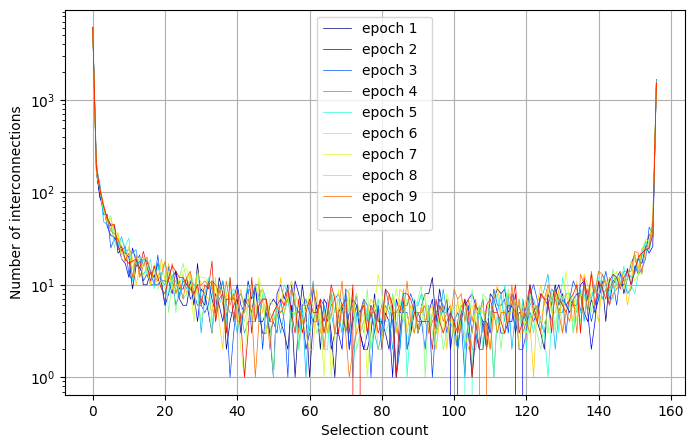

In [9]:
plt.figure(figsize=(8, 5))
cmap = plt.get_cmap('jet')
for i in range(num_epochs):
    plt.plot(data_list[i][1][:-1], data_list[i][0], linewidth=0.5, color=cmap(int(i/num_epochs*255)))
plt.grid()
plt.xlabel("Selection count")
plt.ylabel("Number of interconnections")
plt.yscale("log")
plt.legend(legend_list)
plt.show()